In [102]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [104]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    smiles = []
    groups = []
    families = []
    kinases = []

    for frag in suppl:
        
        # delete dummy atoms
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # remove duplicates based on smiles
        #if s in smiles:
        #    continue
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        fragments.append(Chem.MolFromSmiles(s))
        
        groups.append(frag.GetProp('group'))
        families.append(frag.GetProp('family'))
        kinases.append(frag.GetProp('kinase'))
    
    df['fragment'] = fragments
    df['smiles'] = smiles
    df['subpocket'] = subpocket
    df['group'] = groups
    df['family'] = families
    df['kinase'] = kinases
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7201, 6)

In [105]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

In [106]:
df_AP.drop_duplicates(subset='smiles').shape

(1115, 6)

In [107]:
df_AP.smiles.nunique()

1115

In [108]:
groups = df_AP.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

Calculate number of fragments and unique fragments per kinase group per subpocket.

In [109]:
n_frags = {}
n_unique_frags = {}

for subpocket in subpockets:
    
    df = data[data.subpocket==subpocket]
    
    n_frags_group = {}
    n_unique_frags_group = {}
    
    for group in groups:
        
        df_group = df[df.group==group]
        n = df_group.shape[0]
        n_unique = df_group.smiles.nunique()
        
        n_frags_group[group] = n
        n_unique_frags_group[group] = n_unique
        
    n_frags[subpocket] = n_frags_group
    n_unique_frags[subpocket] = n_unique_frags_group


In [110]:
n_frags = pd.DataFrame(data=n_frags)
n_frags.loc["Total"] = n_frags.sum(axis=0)
n_frags["Total"] = n_frags.sum(axis=1)

In [111]:
n_unique_frags = pd.DataFrame(data=n_unique_frags)
n_unique_frags.loc["Total"] = n_unique_frags.sum(axis=0)
n_unique_frags["Total"] = n_unique_frags.sum(axis=1)

In [112]:
df_n_frags = pd.concat([n_frags,n_unique_frags], axis=1, keys=['All', 'Unique'])
df_n_frags.stack(0)

AP  B1  B2    FP    GA    SE  Total
AGC   All      137   0   2   128    21    16    304
      Unique    70   0   1   102    10    11    194
CAMK  All      368   0   1   241   127   157    894
      Unique   264   0   1   156    54   101    576
CK1   All       49   0   0    33    33    20    135
      Unique    35   0   0    22    11    15     83
CMGC  All      820   3  57   550   331   480   2241
      Unique   411   3  26   286   118   182   1026
Other All      247  10   9   193    98   209    766
      Unique   140   6   6   102    47   114    415
STE   All      113   6   0    69    51    74    313
      Unique    74   5   0    48    31    56    214
TK    All      666  42  20   552   248   501   2029
      Unique   308  13  13   313    95   264   1006
TKL   All      161  37   3   100   115   103    519
      Unique    97  18   3    58    57    70    303
Total All     2561  98  92  1866  1024  1560   7201
      Unique  1399  45  50  1087   423   813   3817

In [113]:
n_frags

,AP,FP,SE,GA,B1,B2,Total
AGC,137,128,16,21,0,2,304
CAMK,368,241,157,127,0,1,894
CK1,49,33,20,33,0,0,135
CMGC,820,550,480,331,3,57,2241
Other,247,193,209,98,10,9,766
STE,113,69,74,51,6,0,313
TK,666,552,501,248,42,20,2029
TKL,161,100,103,115,37,3,519
Total,2561,1866,1560,1024,98,92,7201


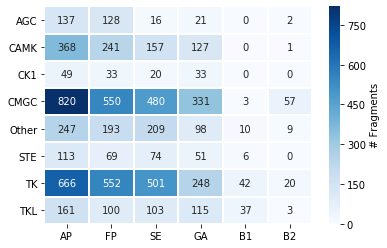

In [114]:
sns.heatmap(n_frags.drop(['Total'], axis=0).drop(['Total'], axis=1), linewidths=1, annot=True, cbar_kws={"label": "# Fragments"}, cmap="Blues", fmt='g')
plt.show()

In [115]:
groups = df_AP.group.unique()
groups

array(['Other', 'TK', 'TKL', 'AGC', 'CMGC', 'CAMK', 'CK1', 'STE'],
      dtype=object)

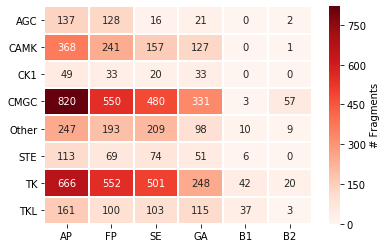

In [116]:
# heatmap without total distribution
sns.heatmap(n_frags.drop('Total', axis=0).drop('Total', axis=1), linewidths=1, annot=True, cbar_kws={"label": "# Fragments"}, cmap="Reds", fmt='g')
plt.show()

In [117]:
n_unique = pd.Series(0, index=groups)
n_frags_per_group = pd.Series(0, index=groups)

# iterate over kinase groups
for group in groups:
    
    dg = data[data.group==group]
    
    n_frags_per_group[group] = len(dg)
    
    # iterate over subpockets
    for sp in subpockets:
        
        dgsp = dg[dg.subpocket==sp]
        nu = dgsp.smiles.nunique()
        
        n_unique.loc[group] += nu

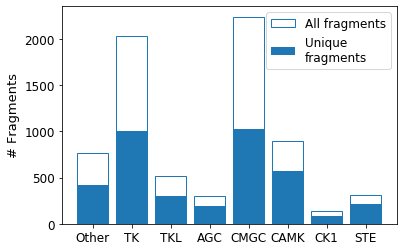

In [118]:
plt.figure()
plt.bar(groups, n_frags_per_group, fill=False, edgecolor='tab:blue')
plt.bar(groups, n_unique, color='tab:blue')
plt.legend(['All fragments', 'Unique\nfragments'], fontsize=12)
plt.ylabel('# Fragments', fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()

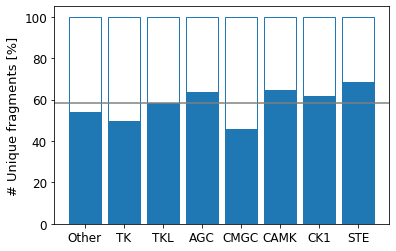

58.252582964794854

In [119]:
p_unique = np.asarray(n_unique)/np.asarray(n_frags_per_group)*100
average = sum(p_unique)/len(groups)
plt.figure()
plt.bar(groups, [100 for x in groups], fill=False, edgecolor='tab:blue')
plt.bar(groups, p_unique, color='tab:blue')
plt.axhline(average, color='grey')
plt.ylabel('# Unique fragments [%]', fontsize=13)
plt.yticks(range(0,101,20), fontsize=12)
plt.xticks(fontsize=12)
plt.show()
average

Fragment distribution across subpockets in each kinase group:

In [120]:
# convert to relative numbers
n_frags.loc['Total'] = n_frags.sum()
total = n_frags.sum(axis=1)
for index, row in n_frags.iterrows():
    n_frags.loc[index] = row/total[index]
n_frags = n_frags*100

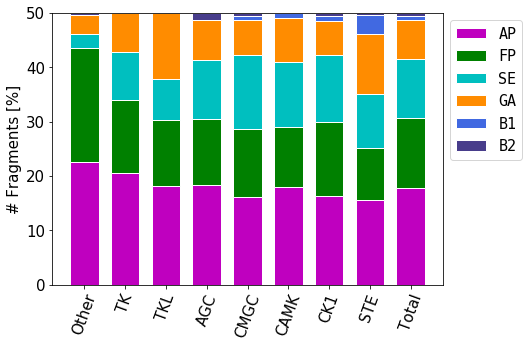

In [121]:
# n_frags as stacked bar plot
r = range(len(groups)+1)
df = n_frags
 
# plot
barWidth = 0.7

plt.figure(figsize=(7,5))
plt.bar(r, df['AP'], edgecolor='white', width=barWidth, color='m', label='AP')
plt.bar(r, df['FP'], bottom=df['AP'], edgecolor='white', width=barWidth, color='g', label='FP')
plt.bar(r, df['SE'], bottom=[i+j for i,j in zip(df['AP'], df['FP'])], edgecolor='white', width=barWidth, color='c', label='SE')
plt.bar(r, df['GA'], bottom=[i+j+k for i,j,k in zip(df['AP'], df['FP'], df['SE'])], 
        edgecolor='white', width=barWidth, color='darkorange', label='GA')
plt.bar(r, df['B1'], bottom=[i+j+k+l for i,j,k,l in zip(df['AP'], df['FP'], df['SE'], df['GA'])], 
        edgecolor='white', width=barWidth, color='royalblue', label='B1')
plt.bar(r, df['B2'], bottom=[i+j+k+l+m for i,j,k,l,m in zip(df['AP'], df['FP'], df['SE'], df['GA'], df['B1'])], 
        edgecolor='white', width=barWidth, color='darkslateblue', label='B2')
 
# Custom x axis
plt.xticks(r, list(groups)+['Total'], fontsize=15, rotation=70)
plt.ylabel('# Fragments [%]', fontsize=15)
plt.yticks(fontsize=15)
# Add a legend

legend = plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size': 15, 'family': 'monospace'})
 
# Show graphic
plt.show()